STLinear vs. Hop‑Biased STLinear vs SPE STLinear 비교 실험

In [1]:
# 기본
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
from collections import defaultdict

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader

# 프로젝트
from dataset.dataset_config import edge_index, edge_attr, week_steps, edge_adj_mat
from dataset.traffic_dataset import TrafficDataset
from utils.Trainer import Trainer
from utils.calculate_performance_index import calculate_performance_index
from models.baselines import GCNMLP, DCRNN, STGCN, MLPBASED, STGAT
from models.STGCN_with_auxiliary_network_model import STGCNWithAux
from models.STLinear import STLinear
from models.STLinear_deriven import STLinear_HopBiased, STLinear_SPE, compute_spe_torch

c:\Users\gauoo\miniconda3\envs\d2l\lib\site-packages\torch_geometric\graphgym\config.py:19: UserWarning: Could not define global config object. Please install 'yacs' via 'pip install yacs' in order to use GraphGym
  warnings.warn("Could not define global config object. Please install "
c:\Users\gauoo\miniconda3\envs\d2l\lib\site-packages\torch_geometric\graphgym\imports.py:14: UserWarning: Please install 'pytorch_lightning' via  'pip install pytorch_lightning' in order to use GraphGym
  warnings.warn("Please install 'pytorch_lightning' via  "


In [2]:
# reproducibility 확보
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# 하이퍼파라미터 & 데이터셋 준비
BATCH_SIZE = 256
EPOCHS = 50
WINDOW = 12                   # 입력 시퀀스 길이
N_PRED = 3                    # 예측 시퀀스 길이
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

data = np.load('dataset/traffic_dataset_13_smoothen.npy')  # (T_total, E, C) (33600, 50, 3)
# train/valid split (예: 시계열 뒤쪽 20%를 검증으로)

split_idx = int(data.shape[0] * 0.8)
train_data, valid_data = data[:split_idx], data[split_idx:]

def collate_fn(batch):
    xs = torch.stack([item.x for item in batch], dim=0)
    ys = torch.stack([item.y for item in batch], dim=0)
    return xs, ys

train_ds = TrafficDataset(train_data, window=WINDOW, randomize=True)
valid_ds = TrafficDataset(valid_data, window=WINDOW, randomize=False)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [3]:
# 모델 생성 함수 (하이퍼파라미터를 인자로 받아 초기화)
def make_models(params, distance_hop_tensor):
    """
    params: dict, 하이퍼파라미터 조합 예시
    distance_hop_tensor: torch.LongTensor, shape (E, E)
    반환: (model_base, model_hopbias)
    """
    common_args = {
        'num_nodes': params['num_nodes'],
        'kernel_size': params['kernel_size'],
        'in_steps': params['in_steps'],
        'out_steps': params['out_steps'],
        'input_embedding_dim': params['input_embedding_dim'],
        'tod_embedding_dim': params['tod_embedding_dim'],
        'dow_embedding_dim': params['dow_embedding_dim'],
        'spatial_embedding_dim': params['spatial_embedding_dim'],
        'adaptive_embedding_dim': params['adaptive_embedding_dim'],
        'feed_forward_dim': params['feed_forward_dim'],
        'num_heads': params['num_heads'],  # base 모델도 num_heads 인자는 있지만, 실제로 사용하지 않을 수 있음
        'num_layers': params['num_layers'],
        'dropout': params['dropout'],
        'use_mixed_proj': True,
    }
    # Base STLinear 모델
    model_base = STLinear(**common_args).to(DEVICE)
    # Hop‑Biased 모델
    common_args_hop = common_args.copy()
    common_args_hop['num_heads'] = params['num_heads']  # d_model % num_heads == 0인지 확인 필요
    # distance_hop_tensor은 미리 준비된 (E,E) LongTensor
    model_hop = STLinear_HopBiased(
        **common_args_hop
    ).to(DEVICE)
    # SPE 모델
    common_args_spe = common_args.copy()
    common_args_spe['num_heads'] = params['num_heads']  # d_model % num_heads == 0인지 확인 필요
    model_spe = STLinear_SPE(
        **common_args_spe, spe_dim=32
    ).to(DEVICE)

    return model_base, model_hop, model_spe


In [4]:
# 3. 하이퍼파라미터 조합 생성 (32가지)
from itertools import product

# 후보 값 정의
param_space = {
    'num_nodes': [50],
    'in_steps': [12],
    'out_steps': [3],
    'kernel_size': [33],
    'input_embedding_dim': [32],
    'tod_embedding_dim': [32],
    'dow_embedding_dim': [32],
    'spatial_embedding_dim': [32],
    'adaptive_embedding_dim': [32],
    'feed_forward_dim': [256],
    'num_heads': [4],           # d_model = input_emb+tod+dow+... = e.g.32+32+32 =96 → 96 % heads ==0? 확인 필요
    'num_layers': [6],
    'dropout': [0.1],
}

# 가능한 모든 조합
all_combinations = list(product(*param_space.values()))

# 딕셔너리 목록으로 변환
keys = list(param_space.keys())
param_dicts = [dict(zip(keys, comb)) for comb in all_combinations]

# 32개만 랜덤으로 추출 (혹은 앞 32개)
random.seed(42)
selected_params = random.sample(param_dicts, 1)

print(f"총 조합 수: {len(all_combinations)}, 선택된 실험 조합 수: {len(selected_params)}")

총 조합 수: 1, 선택된 실험 조합 수: 1


Seed=0, 조합 인덱스=0


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Train 1/1:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/1:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Train 1/1:   0%|          | 0/14 [00:00<?, ?it/s]

Valid 1/1:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Train 1/1:   0%|          | 0/14 [00:00<?, ?it/s]

KeyboardInterrupt: 

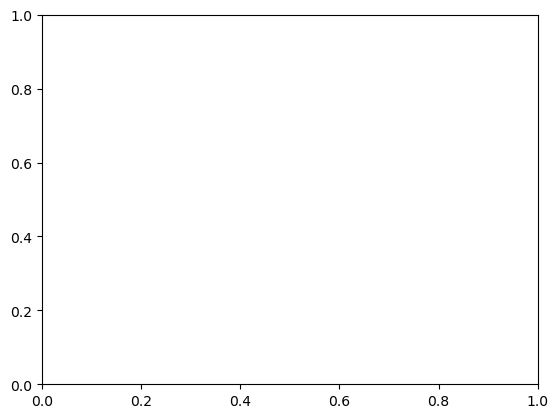

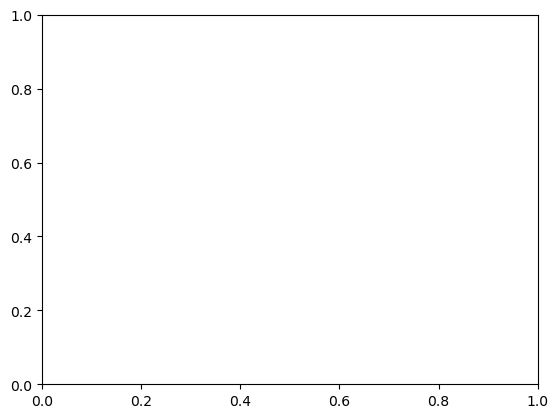

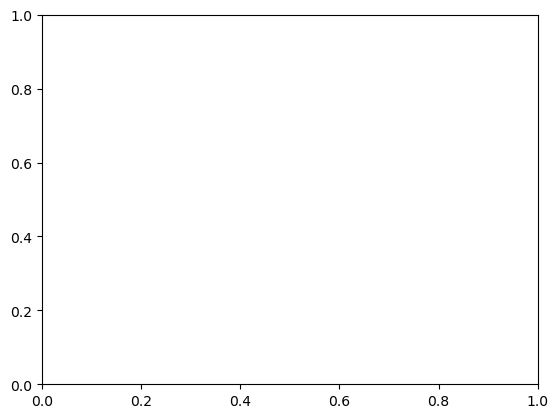

In [6]:
# %% [markdown]
# 4. 반복 실험: 16개의 시드를 사용해 학습 수행
#
# 결과를 기록할 리스트 초기화
results = []
# 시드 목록 (16개)
seeds = list(range(16))

# distance_hop_tensor 준비 (E, E)
# dataset_config.py에서 edge_spd를 가져왔으므로, numpy -> torch.LongTensor로 변환
from dataset.dataset_config import edge_spd
edge_spd_tensor = torch.from_numpy(edge_spd).long().to(DEVICE)

# 학습·평가 함수 정의

def train_and_evaluate(model, train_loader, val_loader, lr, weight_decay, epochs, seed):
    set_seed(seed)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.L1Loss()
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        valid_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        epochs=epochs,
        device=DEVICE,
        print_interval=0,
        plot_interval=5,
        auto_save=True,
    )
    trainer.fit()
    history = trainer.get_history()
    return history

# 메인 루프
for seed in seeds:
    for idx, params in enumerate(selected_params):
        print(f"Seed={seed}, 조합 인덱스={idx}")
        # 모델 초기화
        model_base, model_hop, model_spe = make_models(params, edge_spd_tensor)
        # 하이퍼파라미터: 학습률·감쇠 비율 (고정 혹은 params에 포함하면 추가)
        lr = 5e-5
        weight_decay = 1e-5
        epochs = 1
        
        # 4-1) Base 모델 학습
        history_base = train_and_evaluate(model_base, train_loader, valid_loader, lr, weight_decay, epochs, seed)
        # 4-2) Hop‑Biased 모델 학습
        history_hop  = train_and_evaluate(model_hop,  train_loader, valid_loader, lr, weight_decay, epochs, seed)
        # 4-2-2) SPE 모델 학습
        history_spe  = train_and_evaluate(model_spe,  train_loader, valid_loader, lr, weight_decay, epochs, seed)

        # 4-3) 기록: history에서 valid MAPE, valid loss 추출
        val_mape_base = history_base['valid_mape']  # (length=epochs)
        val_loss_base = history_base['valid_loss']  # (length=epochs)
        val_mape_hop  = history_hop['valid_mape']
        val_loss_hop  = history_hop['valid_loss']
        val_mape_spe  = history_spe['valid_mape']
        val_loss_spe  = history_spe['valid_loss']

        # MAPE=1, 0.5 달성 에폭 찾기
        def first_epoch_leq(arr, threshold):
            for i, v in enumerate(arr):
                if v <= threshold:
                    return i + 1  # 1-based epoch
            return None

        mape1_epoch_base = first_epoch_leq(val_mape_base, 1.0)
        mape05_epoch_base = first_epoch_leq(val_mape_base, 0.5)
        min_mape_base = float(np.min(val_mape_base))
        min_loss_base = float(np.min(val_loss_base))

        mape1_epoch_hop = first_epoch_leq(val_mape_hop, 1.0)
        mape05_epoch_hop = first_epoch_leq(val_mape_hop, 0.5)
        min_mape_hop = float(np.min(val_mape_hop))
        min_loss_hop = float(np.min(val_loss_hop))

        mape1_epoch_spe = first_epoch_leq(val_mape_spe, 1.0)
        mape05_epoch_spe = first_epoch_leq(val_mape_spe, 0.5)
        min_mape_spe = float(np.min(val_mape_spe))
        min_loss_spe = float(np.min(val_loss_spe))

        # 4-4) 결과 저장
        results.append({
            'seed': seed,
            'combo_index': idx,
            'params': params,
            'mape1_epoch_base': mape1_epoch_base,
            'mape05_epoch_base': mape05_epoch_base,
            'min_mape_base': min_mape_base,
            'min_loss_base': min_loss_base,
            'history_base_mape': val_mape_base,
            

            'mape1_epoch_hop': mape1_epoch_hop,
            'mape05_epoch_hop': mape05_epoch_hop,
            'min_mape_hop': min_mape_hop,
            'min_loss_hop': min_loss_hop,
            'history_hop_mape': val_mape_hop,
            
            
            'mape1_epoch_spe': mape1_epoch_spe,
            'mape05_epoch_spe': mape05_epoch_spe,
            'min_mape_spe': min_mape_spe,
            'min_loss_spe': min_loss_spe,
            'history_spe_mape': val_mape_spe,
        })
        
        # 4-5) 동적으로 검증 MAPE-에폭 그래프를 그리기
        # Base 모델 기록된 에폭 수
        epochs_base = len(val_mape_base)  # 예: 30이 아니라 15일 수도 있습니다.

        # HopBias 모델 기록된 에폭 수
        epochs_hop  = len(val_mape_hop)   # 예: 30이 아니라 20일 수도 있습니다.
        
        # spe 모델 
        epochs_spe = len(val_mape_spe)


        plt.figure(figsize=(6, 4))
        # Base 모델은 실제 기록 길이만큼, HopBias 모델도 마찬가지로 그립니다.
        plt.plot(range(1, epochs_base + 1), val_mape_base, label='Base')
        plt.plot(range(1, epochs_hop  + 1), val_mape_hop,  label='HopBias')
        plt.plot(range(1, epochs_spe  + 1), val_mape_spe,  label='speBias')

        plt.axhline(1.0, color='gray', linestyle='--', alpha=0.5)
        plt.axhline(0.5, color='gray', linestyle=':',  alpha=0.5)
        plt.xlabel('Epoch')
        plt.ylabel('Validation MAPE')
        plt.title(f'Seed {seed} - Combo {idx}')
        plt.legend()
        plt.tight_layout()
        plt.show()
